# Your First Training Loop in PyTorch

We will do the same thing but without relying on the Trainer class.

This will allow you to customize your training as per your needs.

**The Training Loop:**

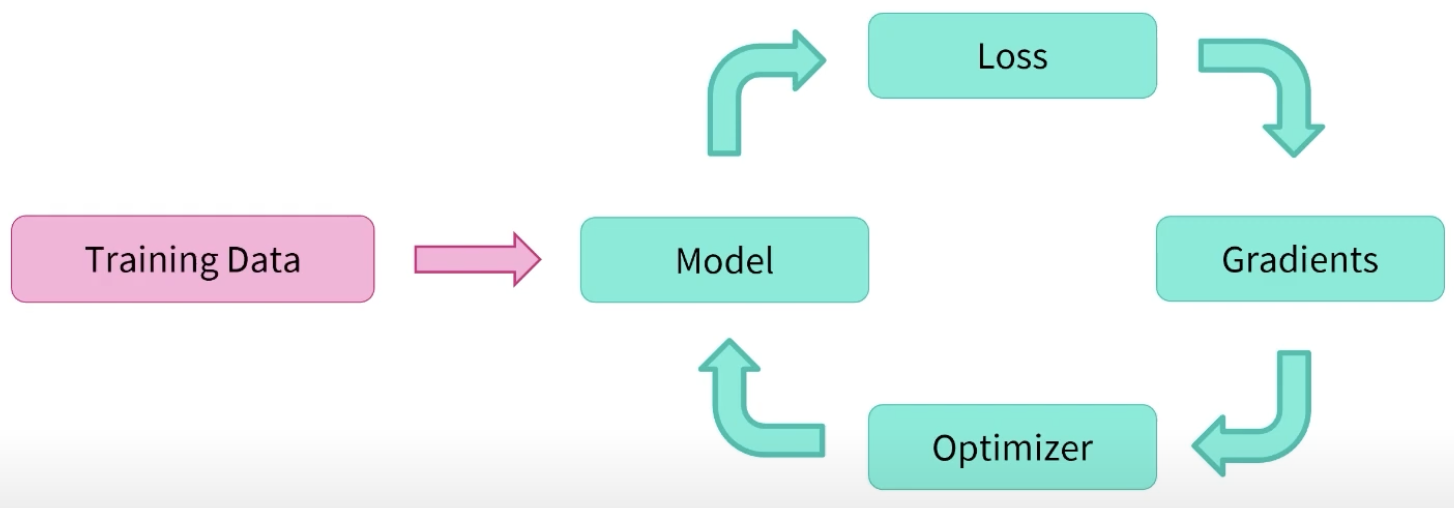

- Training data is sent to the models in batches.
- Model provides predictions on the training data.
- Loss is evaluated on the predictions using the ground truth/labels.
- Gradients (derivatives) are calculated of the model weights and sent to the optimizers.
- Optimizer then updates the weights, and make them a little bit better.
- We then repeat the process with a new batch of the training data.

**Step 1: Preprocessing the data**

In [ ]:
! pip install datasets

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("glue", "mrpc")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["sentence1", "sentence2", "idx"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/408 [00:00<?, ? examples/s]

**Step 2: Convert dataset into batches**

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], shuffle=True, batch_size=8, collate_fn=data_collator
)

In [ ]:
for batch in train_dataloader:
  break
print({k: v.shape for k, v in batch.items()})

{'labels': torch.Size([8]), 'input_ids': torch.Size([8, 66]), 'token_type_ids': torch.Size([8, 66]), 'attention_mask': torch.Size([8, 66])}


**Step 3: Prepare the Model**

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Ignore these for now
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

**Optional Step: Test pre-trained model by sending only one batch**

In [ ]:
batch = {k: v.to(device) for k, v in batch.items()}
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(0.6032, device='cuda:0', grad_fn=<NllLossBackward0>) torch.Size([8, 2])


**Step 4: Establish the optimizer**

In [ ]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Finally, the learning rate scheduler used by default is just a linear decay from the maximum value (5e-5) to 0. To properly define it, we need to know the number of training steps we will take, which is the number of epochs we want to run multiplied by the number of training batches (which is the length of our training dataloader). The `Trainer` uses three epochs by default, so we will follow that:

In [ ]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

1377


**Optional Steps: Setting the device, and the progress bar.**

In [ ]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

  0%|          | 0/1377 [00:00<?, ?it/s]

**Step 5: Setting up the training loop**

In [ ]:
model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss # prediction - actual
        loss.backward() # back_prop

        optimizer.step() # update model weights
        lr_scheduler.step() # change learning rate as per scheduler defined earlier
        optimizer.zero_grad() # reset optimizer after model weights are updated
        progress_bar.update(1)

**Step 6: The evaluate loop**

In [ ]:
! pip install evaluate

In [ ]:
import evaluate

metric = evaluate.load("glue", "mrpc")
model.eval() # change model mode to evaluation
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.8431372549019608, 'f1': 0.8881118881118882}

# The Accelerate Library

Training can happen on multiple kinds of infrastructure:
- 1 CPU
- Multiple CPUs on one machine
- 1 GPU
- Multiple GPUs on one machine
- 1 GPU on each machine; multiple machines
- Multiple GPU on each machine; multiple machines
- TPUs
- TPU Pods


The training loop we defined earlier works fine on a single CPU or GPU. But using the Accelerate library, with just a few adjustments we can enable distributed training on multiple GPUs or TPUs.

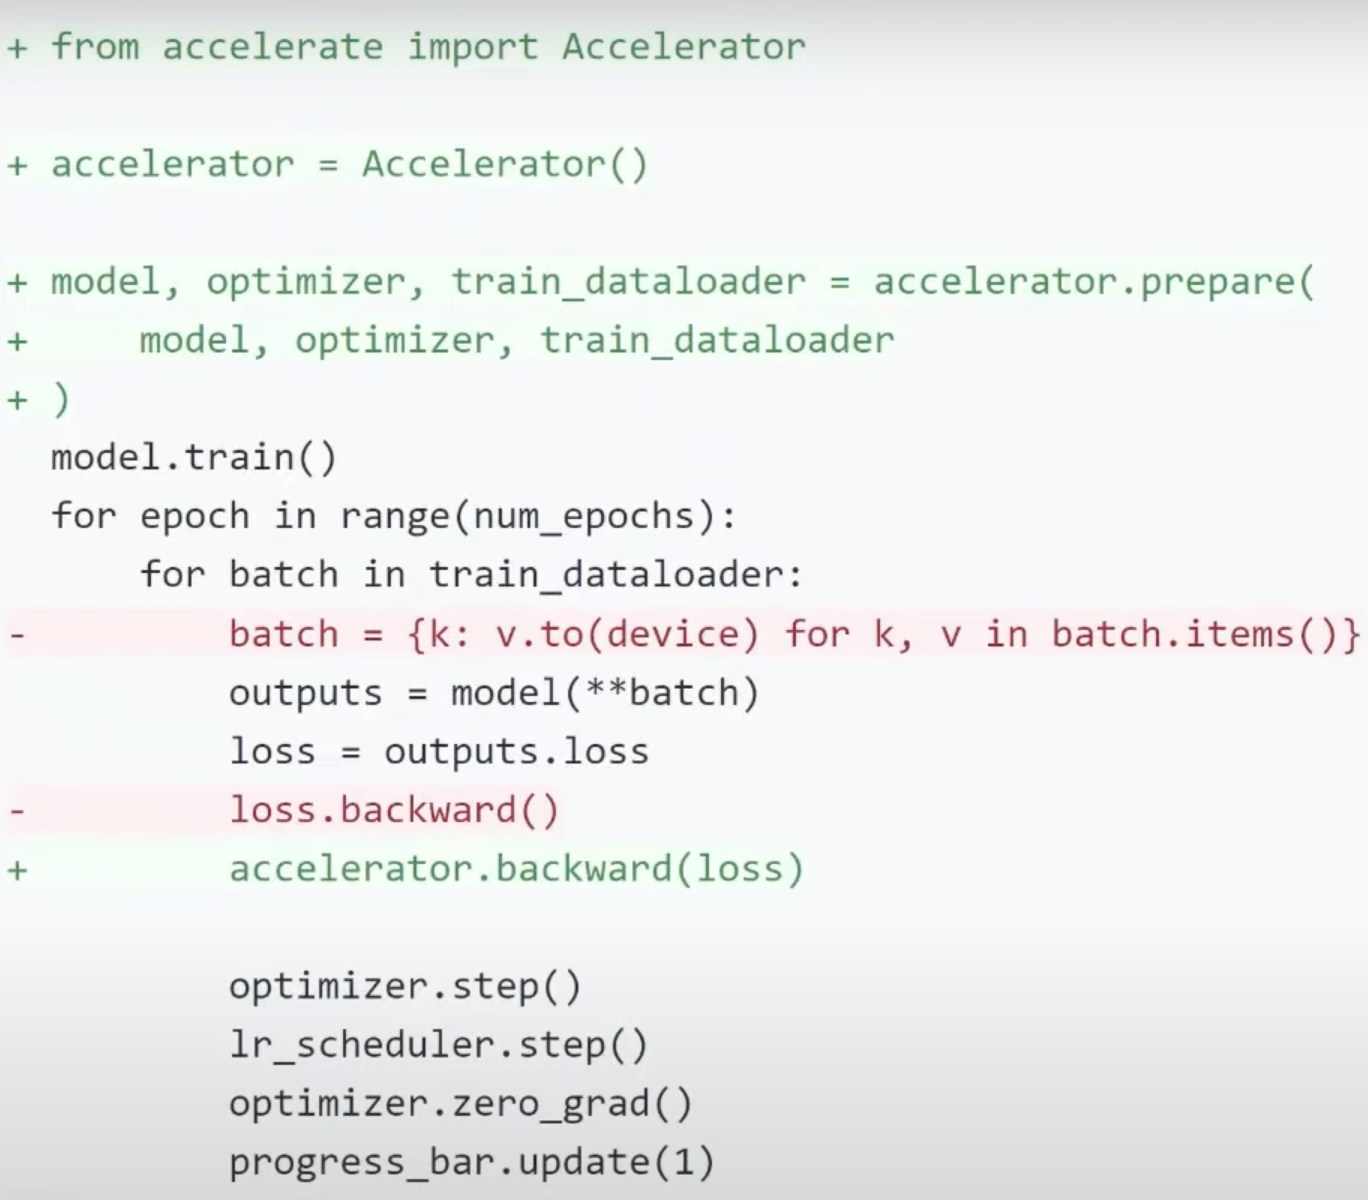

In [ ]:
from accelerate import Accelerator
from transformers import AdamW, AutoModelForSequenceClassification, get_scheduler

accelerator = Accelerator()

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
optimizer = AdamW(model.parameters(), lr=3e-5)



train_dataloader, eval_dataloader, model, optimizer = accelerator.prepare(
     train_dataloader, eval_dataloader, model, optimizer
)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1377 [00:00<?, ?it/s]

Accelerate also handles distributed evaluation.

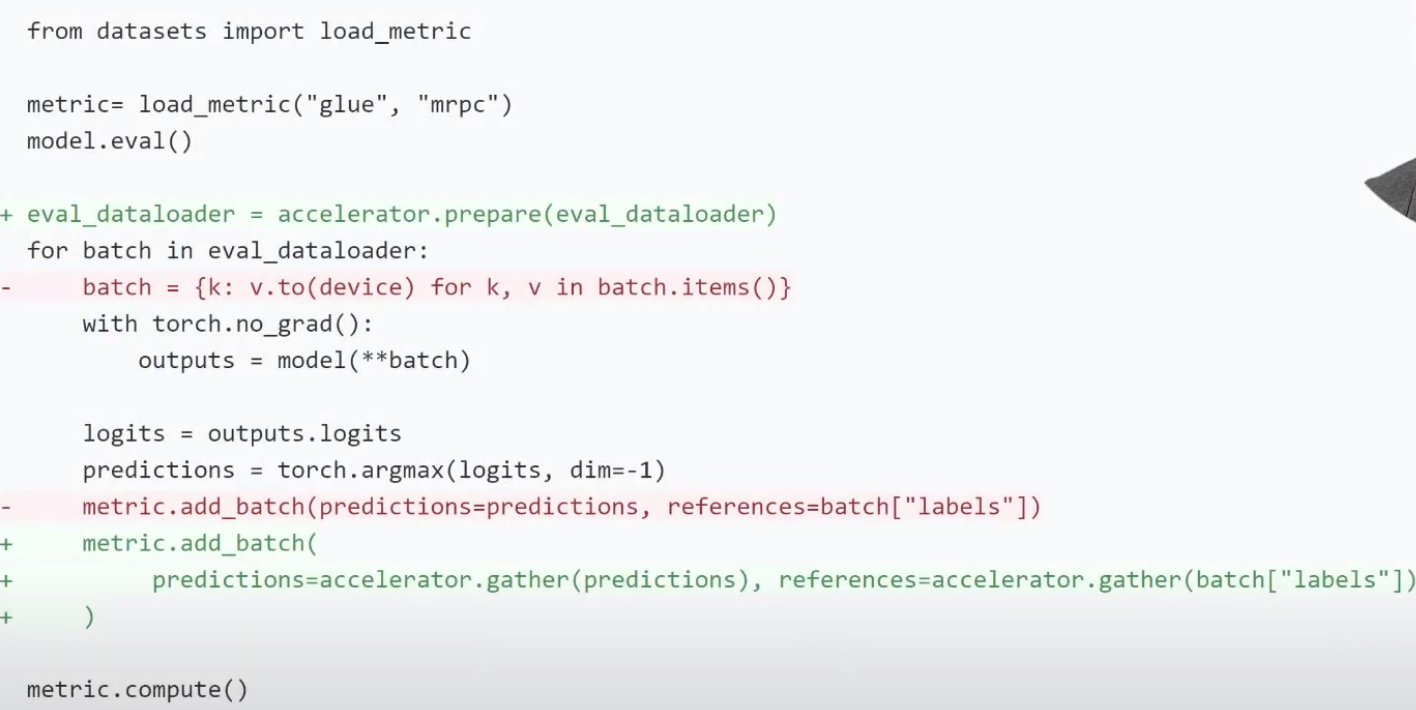

# Hugging Face Models Hub

The Hugging Face Hub is a central platform that enables anyone to discover, use, and contribute new state-of-the-art models. It hosts a wide variety of models, with more than 800,000 publicly available

The [Models Hub](https://huggingface.co/models) is available in the navigatio bar in the top right corner.

## The Filters

The web interface of the models hub can be split into many parts.
On the left you will find categories, which you can use to tailor your model search.
There are many sub-categories:
- Tasks: Multi-modal, Computer vision, NLP, Audio, Tabular, RL, Other.
- Libraries: The backbone frameworks such as PyTorch, Tensorflow, Keras, etc.
- Datasets: Filters models on that specific dataset. Each dataset may have multiple tasks, models, libraries, lanugages associated with it.
- Languages: Models trained on that specific language are selected.
- Licenses: Filter model by licenses.

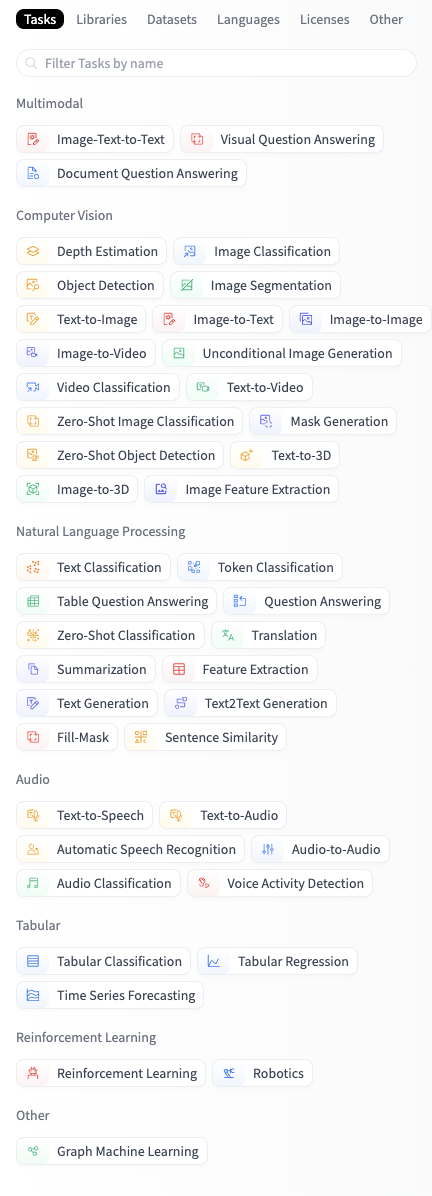

On the right you will find the models available on the hub. The models are sorted by "Trending" by default.

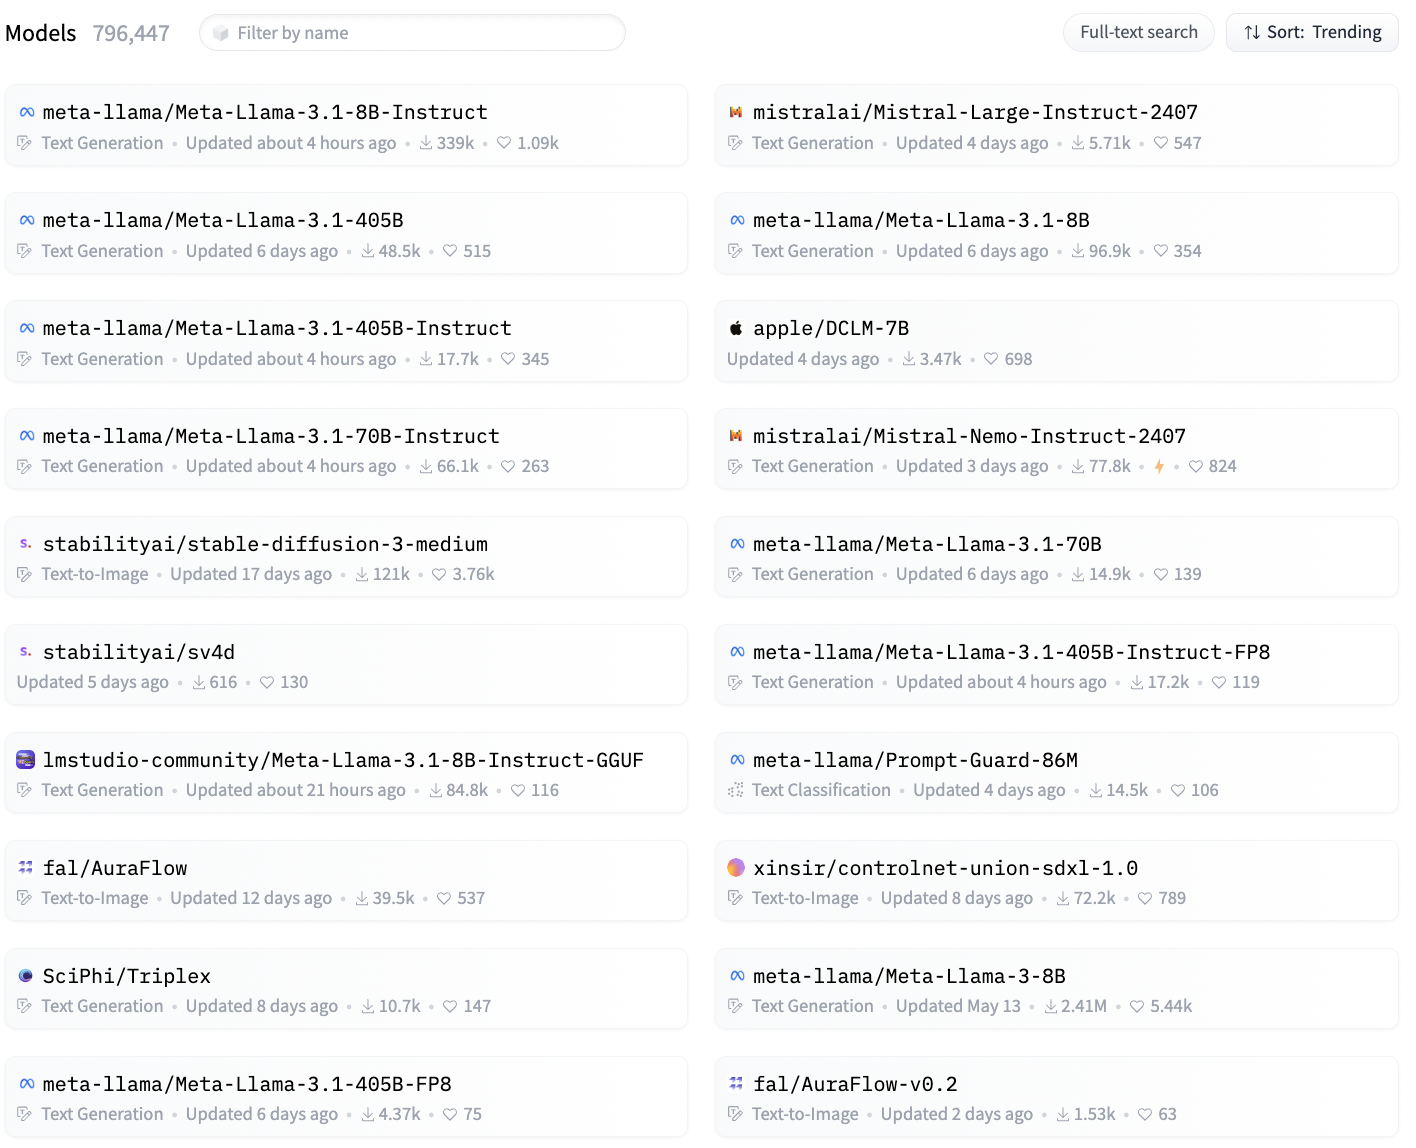

## The Model Card

When you click on the model, you see its **model card**.

The model card should describe:

- the model name, tags, developer (organization),
- its intended uses & potential limitations, including biases and ethical considerations
- the training params and experimental info
- which datasets were used to train your model
- the model’s evaluation results
- code snippets on how to use the model
- any other relevant information

The better crafted a model card is, the easier it will be for other users to leverage the model in their applications.

Review: https://huggingface.co/meta-llama/Meta-Llama-3.1-8B-Instruct

The Files and Versions tab displays the structure of the repository of the model.

You will all the usual features of a git repository.

- Model Files: A list of files associated with the model, typically including the model weights, configuration files, and tokenizer files. These can be downloaded or accessed directly.
- Documentation Files: Links to additional documentation or README files that provide more context or usage instructions.
- Version History: A list of all versions of the model, including details such as version number, date of release, and changes made in each version.

The Community Tab:


- Threads and Topics: A forum-like section where users can start discussions, ask questions, share insights, or report issues related to the model.
- Search and Filter: Tools to search for specific topics or filter discussions by tags, date, or popularity.


- Pull Requests: Information on how to contribute to the model's development, including links to the model's GitHub repository where users can submit pull requests for improvements or bug fixes.
- Community Contributions: Highlights of notable contributions from the community, such as enhancements, new features, or optimizations.


- Meetups and Webinars: Information about upcoming community events, such as webinars, workshops, or meetups related to the model or its applications.
- Release Notes: Updates on new releases, including detailed release notes that describe what has changed, new features, and bug fixes.

## The Inference API

On the right of the model card, is the inference API.
It can be used to play with the model directly.

Review: https://huggingface.co/google-bert/bert-base-uncased

- Train: A button or link that provides guidance or tools to train the model from scratch or fine-tune it on custom datasets. This might include links to training scripts, dataset preparation guidelines, and training configuration files.
- Deploy: Options to deploy the model for use in applications, including links to deployment guides, containerization with Docker, or integration with cloud services like AWS, GCP, or Azure.
- Use Model: Direct links or buttons to start using the model with pre-defined inference scripts or APIs. This typically includes example code snippets, interactive demos, or links to endpoints where the model can be queried

Creating and managing a model repository on Hugging Face involves several steps. Here's a detailed, step-by-step guide:

### Creating a Model Repository

1. **Log In:**
   - Go to the Hugging Face website: [Hugging Face](https://huggingface.co).
   - Click on the "Sign In" button in the upper right corner and log in with your credentials. If you don't have an account, click on "Sign Up" to create one.

2. **Create a New Repository:**
   - Once logged in, click on your profile icon in the upper right corner.
   - Select "New Model" from the dropdown menu.

3. **Repository Details:**
   - **Model Name:** Enter a name for your model repository. This should be unique and descriptive.
   - **Owner:** Select the owner of the repository (your username or an organization you are part of).
   - **Visibility:** Choose the visibility of the repository (public or private). Public repositories are accessible by anyone, while private repositories are only accessible by you and those you invite.
   - **Model Type:** Select the type of model you are uploading (e.g., Transformers, Sentence Transformers, etc.).
   - Click the "Create repository" button.

### Uploading Files to the Repository

4. **Clone the Repository:**
   - You can now see your new repository page. To upload files, you can either use the web interface or Git.
   - To use Git, click on the "Clone" button and copy the URL.
   - Open your terminal and clone the repository:
     ```bash
     git clone https://huggingface.co/username/model-repo-name
     ```
   - Replace `username` and `model-repo-name` with your actual username and repository name.

5. **Add Files:**
   - Navigate into the cloned repository directory:
     ```bash
     cd model-repo-name
     ```
   - Add the necessary model files (e.g., `config.json`, `pytorch_model.bin`, `tokenizer.json`) to this directory.
   - Use Git to add and commit the files:
     ```bash
     git add .
     git commit -m "Initial commit"
     git push
     ```

### Managing the Repository

6. **Edit the Model Card:**
   - On the repository page, click the "Edit" button next to the README.md file.
   - Update the README.md file to include detailed information about your model, such as its purpose, how to use it, and any other relevant details.
   - Click "Commit changes" to save the updates.

7. **Version Control:**
   - To create a new version of your model, you can use Git to make changes and push updates as needed.
   - Tag specific commits to denote different versions:
     ```bash
     git tag v1.0
     git push origin v1.0
     ```

8. **Collaboration:**
   - To invite collaborators, go to the repository page and click on the "Settings" tab.
   - Select "Manage Access" and click "Invite a collaborator."
   - Enter the username or email of the person you want to invite and set their permission level (e.g., Read, Write, Admin).

9. **Community and Discussion:**
   - Engage with the community by using the "Community" tab.
   - Start new discussions, respond to existing ones, and encourage feedback from other users.

10. **Monitor and Update:**
    - Regularly monitor the repository for issues, feedback, and contributions from the community.
    - Keep your model and documentation up-to-date with any improvements or changes.

By following these steps, you can create and manage a model repository on Hugging Face, making your model accessible and useful to the broader AI community.

## `push_toh_hub` API

The simplest way to upload files to the Hub is by leveraging the push_to_hub API.

Before going further, you’ll need to generate an authentication token so that the huggingface_hub API knows who you are and what namespaces you have write access to. If you are in a notebook, you can use the following function to login:

```python
from huggingface_hub import notebook_login

notebook_login()
```

You should be prompted for your username and password, which are the same ones you use to log in to the Hub.

If you have played around with the Trainer API to train a model, the easiest way to upload it to the Hub is to set `push_to_hub=True` when you define your `TrainingArguments`:

```python
from transformers import TrainingArguments

training_args = TrainingArguments(
    "bert-finetuned-mrpc", save_strategy="epoch", push_to_hub=True
)
```

To upload your model to an organization you are a member of, just pass `TrainingArguments` with `hub_model_id = "my_organization/my_repo_name"`.

Once your training is finished, you should do a final `trainer.push_to_hub()` to upload the last version of your model.

It will also generate a model card with all the relevant metadata, reporting the hyperparameters used and the evaluation results!

You can, also, do the same with the tokenizer, so that all the files are now available in this repository:

```
tokenizer.push_to_hub("dummy-model")
```